In [1]:
%tensorflow_version 1.x
import tensorflow as tf 
print(tf.__version__)


TensorFlow 1.x selected.
1.15.2


**Initialize**

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from sklearn.utils import class_weight
from sklearn.model_selection import KFold
import time
import os

read_file=scipy.io.loadmat('Subset_Biosec3.mat') # Load data


**Set Target ID, Model type**

In [3]:
ID = 1 # Target ID
Model_type = 0 # Model type. 0: WS model / 1: ND model

subject = np.arange(1,21).tolist()
print('ID',ID)

ID 1


In [4]:
X_train = np.zeros((2520,150,4)) 
Y_train = np.zeros((2520,1)) 
X_train[0:2400,:,:] = np.array(read_file['train_data']) # Assign original train data
X_train[2400:,:,:] = np.array(read_file['PBGAN_DC_syn'])[subject.index(ID)*120:(subject.index(ID)+1)*120,:,:] # Assign synthetic data (from PBGAN-DC) for only target
Y_train[0:2400,:] = np.array(read_file['train_label']) # Assign original train label
Y_train[2400:] = ID*np.ones((120,1)) # Assign synthetic data's label

X_test = np.array(read_file['test_data']) # Assign original test data
Y_test = np.array(read_file['test_label']) # Assign original test label

# Number of class
n_classes= 20
# Number of features
n_features=X_train.shape[1]


In [5]:
Y_train[np.where(Y_train!=ID)] = 0 # Give '1' to Target ID while others are '0'
Y_test[np.where(Y_test!=ID)] = 0 # Give '1' to Target ID while others are '0'

print(np.unique(Y_train, return_counts=True)) # Check the distribution of train label
print(np.unique(Y_test, return_counts=True)) # Check the distribution of test label

(array([0., 1.]), array([2280,  240]))
(array([0, 1], dtype=uint8), array([456,  24]))


**Onehot Encoding and Data Shuffle**

In [6]:
enc = OneHotEncoder()

randIndx = np.arange(X_train.shape[0])
np.random.shuffle(randIndx)

randIndx2 = np.arange(X_test.shape[0])
np.random.shuffle(randIndx2)

X_train = X_train[randIndx,:,:] # Random shuffle the train data
X_test = X_test[randIndx2,:,:] # Random shuffle the test data
 
Y_train =enc.fit_transform(Y_train[randIndx].reshape(-1,1)).toarray() # Random shuffle with one-hot encoding (train label)
Y_test =enc.fit_transform(Y_test[randIndx2].reshape(-1,1)).toarray() # Random shuffle with one-hot encoding (test label)

train_data, train_target = X_train, Y_train # Final assign train data/label
test_data, test_target = X_test, Y_test # Final assign test data/label

**WS Model Structure**


In [7]:
class WS_Model:

    def __init__(self, sess, name):

        self.sess = sess
        self.name = name
        self._build_net()

    def _build_net(self):

        with tf.variable_scope(self.name):

            self.training = tf.placeholder(tf.bool) # Turn on/off dropout
            self.X = tf.placeholder(tf.float32, [None, 150, 1]) # Input data
            self.Y = tf.placeholder(tf.float32, [None, 2]) # Input label
            self.learning_rate = tf.placeholder(tf.float32) # Learning rate
            self.class_weights = tf.placeholder(tf.float32) # Weight for weighted cross entropy

            # Convolutional Layer #1
            W1 = tf.Variable(tf.random_normal([60, 1, 50], stddev=0.01)) # Initialize parameters from normal distribution 
            conv1 = tf.nn.conv1d(self.X, W1, stride=1, padding='VALID') # Convolution
            relu1 = tf.nn.relu(conv1) # ReLu
            dropout1 = tf.layers.dropout(inputs=relu1, rate=0.5, training=self.training) # Dropout (50%)
            
            # Convolutional Layer #2
            W2 = tf.Variable(tf.random_normal([70, 50, 70], stddev=0.01)) # Initialize parameters from normal distribution 
            conv2 = tf.nn.conv1d(dropout1, W2, stride=1, padding='VALID') # Convolution
            relu2 = tf.nn.relu(conv2) # ReLu                                   
            dropout2 = tf.layers.dropout(inputs=relu2, rate=0.5, training=self.training) # Dropout (50%)            
        
            # FC Layer
            FC = tf.reshape(dropout2, [-1, 22*70])         
            FC_weight = tf.get_variable("FC_weight", shape=[22*70, 2], initializer=tf.contrib.layers.xavier_initializer())
            logits = tf.matmul(FC, FC_weight)             
        
        self.cost = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(self.Y, logits, self.class_weights)) # Weighted cross entropy with logits and labels
        reg_losses = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(FC_weight) # L2 regularization
        self.cost = self.cost + 0.05 * reg_losses # Final cost for optimization
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost) # ADAM optimization
		
        self.sigmoid_out = tf.nn.sigmoid(logits) 
        self.predict = tf.cast(self.sigmoid_out[:,1], tf.float32) # Output from model
                    

    def get_predict(self, x_test, training = False):          

        return self.sess.run(self.predict, feed_dict={self.X: x_test, self.training: training})
    

    def get_cost(self, x_valid, y_valid, weights, training = False):
        
        return self.sess.run(self.cost, feed_dict={self.X: x_valid, 
                                                   self.Y: y_valid, self.class_weights: weights, self.training: training})

    def train(self, x_data, y_data, weights, learning, training = True):

        return self.sess.run(self.optimizer, feed_dict={
             self.X: x_data, self.Y: y_data, self.class_weights: weights, self.learning_rate: learning, self.training: training})        


**ND Model Structure**


In [8]:
class ND_Model:

    def __init__(self, sess, name):

        self.sess = sess
        self.name = name
        self._build_net()

    def _build_net(self):

        with tf.variable_scope(self.name):

            self.training = tf.placeholder(tf.bool) # Turn on/off dropout
            self.X = tf.placeholder(tf.float32, [None, 150, 1]) # Input data
            self.Y = tf.placeholder(tf.float32, [None, 2]) # Input label
            self.learning_rate = tf.placeholder(tf.float32) # Learning rate
            self.class_weights = tf.placeholder(tf.float32) # Weight for weighted cross entropy

            W = tf.Variable(tf.random_normal([7, 1, 1], stddev=0.01)) # Initialize parameters from normal distribution 
            conv = tf.nn.conv1d(self.X, W, stride=1, padding='SAME') # Convolution
			
            # Residual Block #1 
            relu1_1 = tf.nn.relu(conv) # ReLu
            dropout1_1 = tf.layers.dropout(inputs=relu1_1, rate=0.5, training=self.training) # Dropout (50%)
      
            W1_1 = tf.Variable(tf.random_normal([7, 1, 16], stddev=0.01)) # Initialize parameters from normal distribution               
            conv1_1 = tf.nn.conv1d(dropout1_1, W1_1, stride=2, padding='SAME') # Convolution
            relu1_2 = tf.nn.relu(conv1_1) # ReLu
            dropout1_2 = tf.layers.dropout(inputs=relu1_2, rate=0.5, training=self.training) # Dropout (50%)

            W1_2 = tf.Variable(tf.random_normal([7, 16, 16], stddev=0.01)) # Initialize parameters from normal distribution               
            conv1_2 = tf.nn.conv1d(dropout1_2, W1_2, stride=1, padding='SAME') # Convolution
            
            dim_W_1 = tf.Variable(tf.random_normal([1, 1, 16], stddev=0.01)) # Initialize parameters from normal distribution    
            dim_1 = tf.nn.conv1d(conv, dim_W_1, stride=1, padding='SAME') # Convolution
            avg_pool_1 = tf.nn.avg_pool1d(dim_1,ksize=2,strides=2,padding='SAME')

            res_1 = avg_pool_1 + conv1_2 

            # Residual Block #2 
            relu2_1 = tf.nn.relu(res_1) # ReLu
            dropout2_1 = tf.layers.dropout(inputs=relu2_1, rate=0.5, training=self.training) # Dropout (50%)

            W2_1 = tf.Variable(tf.random_normal([7, 16, 32], stddev=0.01)) # Initialize parameters from normal distribution 
            conv2_1 = tf.nn.conv1d(dropout2_1, W2_1, stride=2, padding='SAME') # Convolution
            relu2_2 = tf.nn.relu(conv2_1) # ReLu
            dropout2_2 = tf.layers.dropout(inputs=relu2_2, rate=0.5, training=self.training) # Dropout (50%)

            W2_2 = tf.Variable(tf.random_normal([7, 32, 32], stddev=0.01)) # Initialize parameters from normal distribution               
            conv2_2 = tf.nn.conv1d(dropout2_2, W2_2, stride=1, padding='SAME') # Convolution

            dim_W_2 = tf.Variable(tf.random_normal([1, 16, 32], stddev=0.01)) # Initialize parameters from normal distribution    
            dim_2 = tf.nn.conv1d(res_1, dim_W_2, stride=1, padding='SAME') # Convolution
            avg_pool_2 = tf.nn.avg_pool1d(dim_2,ksize=2,strides=2,padding='SAME')

            res_2 = avg_pool_2 + conv2_2 

             
            # Residual Block #3 
            relu3_1 = tf.nn.relu(res_2) # ReLu
            dropout3_1 = tf.layers.dropout(inputs=relu3_1, rate=0.5, training=self.training) # Dropout (50%)

            W3_1 = tf.Variable(tf.random_normal([7, 32, 64], stddev=0.01)) # Initialize parameters from normal distribution 
            conv3_1 = tf.nn.conv1d(dropout3_1, W3_1, stride=2, padding='SAME') # Convolution
            relu3_2 = tf.nn.relu(conv3_1) # ReLu
            dropout3_2 = tf.layers.dropout(inputs=relu3_2, rate=0.5, training=self.training) # Dropout (50%)

            W3_2 = tf.Variable(tf.random_normal([7, 64, 64], stddev=0.01)) # Initialize parameters from normal distribution               
            conv3_2 = tf.nn.conv1d(dropout3_2, W3_2, stride=1, padding='SAME') # Convolution

            dim_W_3 = tf.Variable(tf.random_normal([1, 32, 64], stddev=0.01)) # Initialize parameters from normal distribution    
            dim_3 = tf.nn.conv1d(res_2, dim_W_3, stride=1, padding='SAME') # Convolution
            avg_pool_3 = tf.nn.avg_pool1d(dim_3,ksize=2,strides=2,padding='SAME')

            res_3 = avg_pool_3 + conv3_2 


            # Residual Block #4 
            relu4_1 = tf.nn.relu(res_3) # ReLu
            dropout4_1 = tf.layers.dropout(inputs=relu4_1, rate=0.5, training=self.training) # Dropout (50%)

            W4_1 = tf.Variable(tf.random_normal([7, 64, 128], stddev=0.01)) # Initialize parameters from normal distribution 
            conv4_1 = tf.nn.conv1d(dropout4_1, W4_1, stride=2, padding='SAME') # Convolution
            relu4_2 = tf.nn.relu(conv4_1) # ReLu
            dropout4_2 = tf.layers.dropout(inputs=relu4_2, rate=0.5, training=self.training) # Dropout (50%)

            W4_2 = tf.Variable(tf.random_normal([7, 128, 128], stddev=0.01)) # Initialize parameters from normal distribution               
            conv4_2 = tf.nn.conv1d(dropout4_2, W4_2, stride=1, padding='SAME') # Convolution

            dim_W_4 = tf.Variable(tf.random_normal([1, 64, 128], stddev=0.01)) # Initialize parameters from normal distribution    
            dim_4 = tf.nn.conv1d(res_3, dim_W_4, stride=1, padding='SAME') # Convolution
            avg_pool_4 = tf.nn.avg_pool1d(dim_4,ksize=2,strides=2,padding='SAME')

            res_4 = avg_pool_4 + conv4_2 

            # Residual Block #5 
            relu5_1 = tf.nn.relu(res_4) # ReLu
            dropout5_1 = tf.layers.dropout(inputs=relu5_1, rate=0.5, training=self.training) # Dropout (50%)

            W5_1 = tf.Variable(tf.random_normal([7, 128, 256], stddev=0.01)) # Initialize parameters from normal distribution 
            conv5_1 = tf.nn.conv1d(dropout5_1, W5_1, stride=2, padding='SAME') # Convolution
            relu5_2 = tf.nn.relu(conv5_1) # ReLu
            dropout5_2 = tf.layers.dropout(inputs=relu5_2, rate=0.5, training=self.training) # Dropout (50%)

            W5_2 = tf.Variable(tf.random_normal([7, 256, 256], stddev=0.01)) # Initialize parameters from normal distribution               
            conv5_2 = tf.nn.conv1d(dropout5_2, W5_2, stride=1, padding='SAME') # Convolution

            dim_W_5 = tf.Variable(tf.random_normal([1, 128, 256], stddev=0.01)) # Initialize parameters from normal distribution    
            dim_5 = tf.nn.conv1d(res_4, dim_W_5, stride=1, padding='SAME') # Convolution
            avg_pool_5 = tf.nn.avg_pool1d(dim_5,ksize=2,strides=2,padding='SAME')

            res_5 = avg_pool_5 + conv5_2         

            # FC Layer
            FC_relu = tf.nn.relu(res_5) # ReLu

            FC = tf.reshape(FC_relu, [-1, 5*256])         
            FC_weight = tf.get_variable("FC_weight", shape=[5*256, 2], initializer=tf.contrib.layers.xavier_initializer())
            logits = tf.matmul(FC, FC_weight)             
        
        self.cost = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(self.Y, logits, self.class_weights)) # Weighted cross entropy with logits and labels
        # L2 regularization
        reg_losses = tf.nn.l2_loss(W) + tf.nn.l2_loss(W1_1) + tf.nn.l2_loss(W1_2) + tf.nn.l2_loss(W2_1) + \
         tf.nn.l2_loss(W2_2) + tf.nn.l2_loss(W3_1) + tf.nn.l2_loss(W3_2) + tf.nn.l2_loss(W4_1) + tf.nn.l2_loss(W4_2) + tf.nn.l2_loss(W5_1) + tf.nn.l2_loss(W5_2) + tf.nn.l2_loss(FC_weight)

        self.cost = self.cost + 0.05 * reg_losses # Final cost for optimization
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost) # ADAM optimization
		
        self.sigmoid_out = tf.nn.sigmoid(logits) 
        self.predict = tf.cast(self.sigmoid_out[:,1], tf.float32) # Output from model

    def get_predict(self, x_test, training = False):          

        return self.sess.run(self.predict, feed_dict={self.X: x_test, self.training: training})
    

    def get_cost(self, x_valid, y_valid, weights, training = False):
        
        return self.sess.run(self.cost, feed_dict={self.X: x_valid, 
                                                   self.Y: y_valid, self.class_weights: weights, self.training: training})

    def train(self, x_data, y_data, weights, learning, training = True):

        return self.sess.run(self.optimizer, feed_dict={
             self.X: x_data, self.Y: y_data, self.class_weights: weights, self.learning_rate: learning, self.training: training})        


**Train the Model**

In [9]:
# Hyperparameters
learning_rate = 0.0001
training_epochs = 60 # Number of epoch
batch_size = 252 # Mini-batch size
num_cv = 10 # Number of fold in cross validation 
bag_size = 2268  # Size of train set in cross validation

valid_cost = np.zeros((training_epochs,4))


sess = tf.Session()
models = []
num_models = 4 # Generate 4 CNNs for each input (i.e. DTW,TP,FP,Cubic)

if Model_type == 0:

  for m in range(num_models):
      models.append(WS_Model(sess, "model" + str(m)))    
else:
  for m in range(num_models):
      models.append(ND_Model(sess, "model" + str(m)))    

sess.run(tf.global_variables_initializer())

start_time = time.time() # For checking training time

print('Learning Started!')

# Train start
for epoch in range(training_epochs):
         
    total_batch = int(bag_size / batch_size)
    valid_cost_cv = [0,0,0,0]
    
    cv = KFold(n_splits=num_cv, shuffle=True)
    for train_index, test_index in cv.split(train_data): # Divide the train and test set for cross validation
        cv_train_data, cv_validate_data = train_data[train_index], train_data[test_index]
        cv_train_target, cv_validate_target = train_target[train_index], train_target[test_index]    
                    
        for m_idx, m in enumerate(models):
            
            if m_idx==0: # Train data/label for DTW's CNN model
              training, validating = cv_train_data[:,:,0], cv_validate_data[:,:,0]
              training_target, validating_target = cv_train_target, cv_validate_target
            if m_idx==1: # Train data/label for TP's CNN model
              training, validating = cv_train_data[:,:,1], cv_validate_data[:,:,1]
              training_target, validating_target = cv_train_target, cv_validate_target
            if m_idx==2: # Train data/label for FP's CNN model
              training, validating = cv_train_data[:,:,2], cv_validate_data[:,:,2]
              training_target, validating_target = cv_train_target, cv_validate_target            
            if m_idx==3: # Train data/label for Cubic's CNN model
              training, validating = cv_train_data[:,:,3], cv_validate_data[:,:,3]
              training_target, validating_target = cv_train_target, cv_validate_target            

            training = np.reshape(training,[len(training),n_features,1])
            validating = np.reshape(validating,[len(validating),n_features,1])

            for i in range(total_batch):

                batch_xs, batch_ys = training[batch_size*i:batch_size*(i+1),:], training_target[batch_size*i:batch_size*(i+1)]                
                pos_weight = (n_classes - 1) # Weight for weighted cross entropy

                _ = m.train(batch_xs, batch_ys, pos_weight, learning_rate) # Train the model with mini-batch data

                pos_weight = 1 # No specific weight for weighted cross entropy when calculating validation and test set
                        
            valid_cost_cv[m_idx] += m.get_cost(validating, validating_target, pos_weight) # Cost for validation set
            
    valid_cost[epoch] =np.divide(valid_cost_cv ,num_cv) # Average cost for validation set
    
    if ((epoch+1)%5) == 0: # Print the average cost
        print('Epoch:', '%04d' % (epoch + 1), 'Validating_cost_DTW =', round(valid_cost[epoch,0],3),' Validating_cost_TP =', round(valid_cost[epoch,1],3),' Validating_cost_FP =', round(valid_cost[epoch,2],3),' Validating_cost_Cubic =', round(valid_cost[epoch,3],3))         
        
print('Learning Finished!')

end_time = time.time()
elapsed = end_time - start_time # For checking training time

print('Training time: {:.2f} seconds'.format(elapsed)) # Training time



Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `layer.__call__` method instead.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Learning Started!
Epoch: 0005 Validating_cost_DTW = 0.698  Validating_cost_TP = 0.545  Validating_cost_FP = 0.584  Validating_cost_Cubic = 0.535
Epoch: 0010 Validating_cost_DTW = 0.509  Validating_cost_TP = 0.386  Validating_cost_FP = 0.419  Validating_cost_Cubic = 0.401
Epoch: 0015 Validating_cost_DTW = 0.436  Validating_cost_TP = 0.33  Validating_cost_FP = 0.356  Validating_cost_Cubic = 0.349
Epoch: 0020 Validating_cost_DTW = 0.406  Validating_cost_TP = 0.299  Validating_cost_FP = 0.326  Validatin

**Validation Cost Plot**

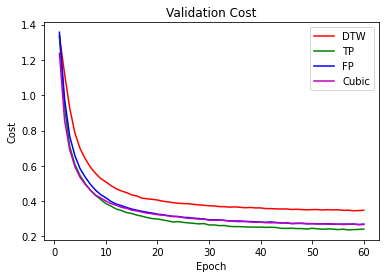

In [10]:
fig = plt.figure()
ax = plt.subplot(111)

x_axis = np.linspace(1.0, training_epochs, num=training_epochs)
ax.plot(x_axis, valid_cost[:,0],'r', label='DTW')
ax.plot(x_axis, valid_cost[:,1],'g', label='TP')
ax.plot(x_axis, valid_cost[:,2],'b', label='FP')
ax.plot(x_axis, valid_cost[:,3],'m', label='Cubic')

ax.legend()
plt.title('Validation Cost')
plt.xlabel('Epoch')
plt.ylabel('Cost')

plt.show()

**Sum Fusion**

In [11]:
testing_0 = np.reshape(test_data[:,:,0], [len(test_data[:,:,0]),n_features,1])
testing_1 = np.reshape(test_data[:,:,1], [len(test_data[:,:,1]),n_features,1])
testing_2 = np.reshape(test_data[:,:,2], [len(test_data[:,:,2]),n_features,1])
testing_3 = np.reshape(test_data[:,:,3], [len(test_data[:,:,3]),n_features,1])

start_time_test = time.time() # For checking fusion time

test_logit_0 =  models[0].get_predict(testing_0) # Score from DTW's CNN model
test_logit_1 =  models[1].get_predict(testing_1) # Score from TP's CNN model
test_logit_2 =  models[2].get_predict(testing_2) # Score from FP's CNN model
test_logit_3 =  models[3].get_predict(testing_3) # Score from Cubic's CNN model


In [12]:
thres = np.arange(0, 1.001, 0.001) # Threshold for calculating performances

thres_matrix_test = np.zeros((len(test_target),len(thres)))
total_matrix_test = np.zeros((len(thres),4)) # Saving performances: Accuracy, FAR, FRR, Recall (order of column)

test_logit = 0.25*test_logit_0 + 0.25*test_logit_1 + 0.25*test_logit_2 + 0.25*test_logit_3 # Sum fusion with each score


for j in range(len(thres)):
    for i in range(len(test_target)):
        if test_logit[i] < thres[j]:
            thres_matrix_test[i,j] = 0 # Below threshold -> Not target
        else:
            thres_matrix_test[i,j] = 1 # Above (and equal) threshold -> Target


# Calculate performances

for i in range(len(thres)):

    equal_logit = np.equal(thres_matrix_test[:,i], test_target[:,1]) 
    unique2, True_pos_neg_test = np.unique(thres_matrix_test[np.where(equal_logit==True),i], return_counts=True)
    unique3, False_pos_neg_test = np.unique(thres_matrix_test[np.where(equal_logit==False),i], return_counts=True) 

    if np.shape(True_pos_neg_test)==(1,):
        if unique2[0] == 0:
            True_pos_neg_test = [True_pos_neg_test[0], 0]
        else:
            True_pos_neg_test = [0, True_pos_neg_test[0]]

    if np.shape(False_pos_neg_test)==(1,):
        if unique3[0] == 0:
            False_pos_neg_test = [False_pos_neg_test[0], 0]
        else:
            False_pos_neg_test = [0, False_pos_neg_test[0]]

    if np.shape(True_pos_neg_test)==(0,):
        True_pos_neg_test = [0, 0]

    if np.shape(False_pos_neg_test)==(0,):
        False_pos_neg_test = [0, 0]

    Recall_test= True_pos_neg_test[1]/(True_pos_neg_test[1]+False_pos_neg_test[0])
    Specific_test = True_pos_neg_test[0] /(True_pos_neg_test[0]+False_pos_neg_test[1])

    ACC_test = (True_pos_neg_test[0]+True_pos_neg_test[1]) / (len(test_target))
    FAR_test = 1 - Specific_test
    FRR_test = 1 - Recall_test

    total_matrix_test[i,:] = ACC_test, FAR_test, FRR_test, Recall_test

fusion_time = time.time() - start_time_test # For checking fusion time
elapsed = elapsed + fusion_time

print('Final building time: {:.2f} seconds'.format(elapsed))

Final building time: 79.50 seconds


**Result for Target ID**

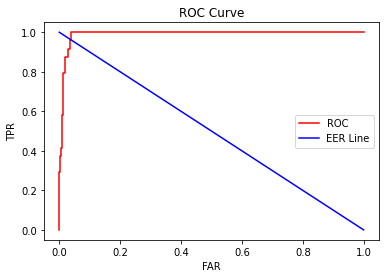

Accuracy: 96.04% 
EER: 4.06% 


In [13]:
EER_line = thres[::-1]

fig2 = plt.figure()
ax2 = plt.subplot(111)
ax2.plot(total_matrix_test[:,1], total_matrix_test[:,3],'r',label='ROC')
ax2.plot(thres, EER_line, 'b',label='EER Line')
ax2.legend()
plt.title('ROC Curve')
plt.xlabel('FAR')
plt.ylabel('TPR')
plt.show()

EER_loc_test = np.argmin(abs(total_matrix_test[:,1] - total_matrix_test[:,2]))
print('Accuracy: {:.2f}% '.format(100*total_matrix_test[EER_loc_test,0]))
print('EER: {:.2f}% '.format(100*(total_matrix_test[EER_loc_test,1]+total_matrix_test[EER_loc_test,2])/2))

